In [4]:
# Cell 1 — Installs & Imports
import os, random, time, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm.auto import tqdm
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms

import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score, classification_report
from sklearn.preprocessing import LabelEncoder

# --- Install missing packages if needed ---
# !pip install timm xgboost scikit-image --quiet
# ----------------------------------------

warnings.filterwarnings('ignore')

# device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)
if DEVICE.type == "cuda":
    try:
        print("GPU:", torch.cuda.get_device_name(0))
    except Exception:
        pass

Device: cuda
GPU: Tesla T4


In [5]:
# Cell 2 — Reproducibility & Paths
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if DEVICE.type == 'cuda':
        torch.cuda.manual_seed_all(seed)

seed_everything(42)

# Kaggle dataset paths (assuming standard RSNA layout)
DATA_PATH = Path('/kaggle/input/rsna-bone-age')
TRAIN_CSV_PATH = DATA_PATH / 'boneage-training-dataset.csv'
TEST_CSV_PATH  = DATA_PATH / 'boneage-test-dataset.csv'
TRAIN_IMG_DIR = DATA_PATH / 'boneage-training-dataset' / 'boneage-training-dataset'
TEST_IMG_DIR  = DATA_PATH / 'boneage-test-dataset' / 'boneage-test-dataset'

print("Train CSV found:", TRAIN_CSV_PATH.exists())

Train CSV found: True


In [6]:
# Cell 3 — Load & Process Data
train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df  = pd.read_csv(TEST_CSV_PATH)

train_df = train_df.rename(columns={'id':'Case ID', 'boneage':'boneage_months', 'male':'male'})
# ensure IDs are strings
train_df['Case ID'] = train_df['Case ID'].astype(str)
test_df['Case ID']  = test_df['Case ID'].astype(str)

# create sex column for readability
train_df['sex'] = np.where(train_df['male']==1, 'M', 'F')
test_df['sex']  = np.where(test_df['Sex'].str.upper()=='M', 'M', 'F') if 'Sex' in test_df.columns else np.where(test_df['sex']=='M','M','F')
train_df['sex_int'] = train_df['male'].astype(int)

# create balanced 5 quantile bins (labels 0..4)
NUM_CLASSES = 5
train_df['age_bin'] = pd.qcut(train_df['boneage_months'], q=NUM_CLASSES, labels=False, duplicates='drop')
train_df['age_bin'] = train_df['age_bin'].astype(int)

# map class names
CLASS_NAMES = {
    0: "Child",
    1: "Pre-Teen",
    2: "Teen",
    3: "Young Adult",
    4: "Adult"
}

print("Class distribution (Quantile Bins):\n", train_df[['boneage_months','age_bin']].groupby('age_bin').agg(['count','min','max']))



Class distribution (Quantile Bins):
         boneage_months          
                 count  min  max
age_bin                         
0                 2948    1   94
1                 2332   96  120
2                 2540  121  144
3                 2615  146  162
4                 2176  163  228


In [7]:
# Cell 4 — Train / Val / Test split (internal)
# stratify by sex and bin to maintain distribution
train_split, temp = train_test_split(train_df, test_size=0.30, random_state=42, stratify=train_df['age_bin'])
val_df, val_test_df = train_test_split(temp, test_size=0.50, random_state=42, stratify=temp['age_bin'])

print("Splits sizes -> Train:", len(train_split), "Val:", len(val_df), "Holdout Test:", len(val_test_df))

train_df_used = train_split.reset_index(drop=True)
val_df_used = val_df.reset_index(drop=True)
test_holdout_df = val_test_df.reset_index(drop=True)

Splits sizes -> Train: 8827 Val: 1892 Holdout Test: 1892


In [8]:
# Cell 5 — Enhanced Augmentation & Dataset
IMG_SIZE = 384

# Stronger augmentations for training
train_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15), # Increased rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Brightness/Contrast jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [9]:
# Cell 6 — PyTorch Dataset
class BoneAgeClassDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id = str(row['Case ID'])
        img_path = self.img_dir / f"{img_id}.png"
        
        # Read as grayscale then convert to RGB (standard practice for medical X-rays)
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            # Handle missing image (should not happen in RSNA dataset)
            # print(f"Warning: Image not found at {img_path}")
            img = np.zeros((IMG_SIZE,IMG_SIZE), dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        if self.transform:
            img = self.transform(img)

        # Sex must be provided as a 0 or 1 index for nn.Embedding
        sex = row.get('sex_int', 1) if 'sex_int' in row else (1 if row.get('sex','M')=='M' else 0)


        if self.is_test:
            # For the external Kaggle test set, we only return image, ID, and sex
            return img, img_id, torch.tensor(sex, dtype=torch.long)
        else:
            # For internal train/val/test, return image, ordinal label, and sex
            label = int(row['age_bin'])
            return img, torch.tensor(label, dtype=torch.long), torch.tensor(sex, dtype=torch.long)



In [10]:
# Cell 7 — Dataloaders
BATCH_SIZE = 16

train_ds = BoneAgeClassDataset(train_df_used, TRAIN_IMG_DIR, transform=train_tf, is_test=False)
val_ds   = BoneAgeClassDataset(val_df_used,   TRAIN_IMG_DIR, transform=val_tf,   is_test=False)
test_holdout_ds = BoneAgeClassDataset(test_holdout_df, TRAIN_IMG_DIR, transform=val_tf, is_test=False)
kaggle_test_ds = BoneAgeClassDataset(test_df, TEST_IMG_DIR, transform=val_tf, is_test=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_holdout_loader = DataLoader(test_holdout_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
kaggle_test_loader  = DataLoader(kaggle_test_ds, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

print("Loaders ready. Training on:", len(train_ds))

Loaders ready. Training on: 8827


In [11]:
# Cell 8 — HOG + XGBoost baseline (classification) - Same as previous, good for comparison
from skimage import color, exposure
from sklearn.preprocessing import StandardScaler

def extract_hog_features_cv2(image, pixels_per_cell=(16,16), cells_per_block=(2,2), orientations=9):
    # Resize to 128x128 for HOG stability
    img_resized = cv2.resize(image, (128, 128))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    
    # Define HOG parameters
    winSize = (128, 128)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    
    feat = hog.compute(gray)
    return feat.flatten()

def build_hog_dataset_with_sex(df, img_dir, max_samples=None):
    X_list, y_list = [], []
    rows_iter = df.itertuples() if max_samples is None else df.sample(n=min(max_samples, len(df)), random_state=42).itertuples()
    
    for r in tqdm(rows_iter, total=(None if max_samples is None else max_samples), desc="HOG build"):
        img_path = Path(img_dir) / f"{r._1}.png" # Case ID is index 1
        img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        if img is None: continue
            
        feat = extract_hog_features_cv2(img)
        
        # Add sex as extra feature (must be 0 or 1, same as sex_int)
        sex_feature = np.array([r.sex_int], dtype=np.float32)
        X_list.append(np.concatenate([feat, sex_feature]))
        y_list.append(int(r.age_bin))
        
    X = np.vstack(X_list)
    y = np.array(y_list, dtype=np.int32)
    return X, y

# Extract HOG for a subset for comparison
HOG_SAMPLES = 3000
X_train_hog, y_train_hog = build_hog_dataset_with_sex(train_df_used, TRAIN_IMG_DIR, max_samples=HOG_SAMPLES)
X_val_hog, y_val_hog = build_hog_dataset_with_sex(val_df_used, TRAIN_IMG_DIR, max_samples=HOG_SAMPLES//3)

# Scale HOG features
scaler_hog = StandardScaler()
X_train_hog_scaled = scaler_hog.fit_transform(X_train_hog)
X_val_hog_scaled   = scaler_hog.transform(X_val_hog)

# XGBoost classifier
import xgboost as xgb
dtrain = xgb.DMatrix(X_train_hog_scaled, label=y_train_hog)
dval   = xgb.DMatrix(X_val_hog_scaled, label=y_val_hog)

params = {
    "objective":"multi:softmax",
    "num_class": NUM_CLASSES,
    "eval_metric":"mlogloss",
    "learning_rate":0.05,
    "max_depth":6,
    "verbosity":0
}
bst = xgb.train(params, dtrain, num_boost_round=150, evals=[(dval, 'val')], early_stopping_rounds=15, verbose_eval=30)

# evaluate baseline
y_val_pred_hog = bst.predict(dval).astype(int)
print("\n=== HOG+XGBoost Baseline Metrics (Validation Subset) ===")
print(f"Accuracy : {accuracy_score(y_val_hog, y_val_pred_hog):.4f}")
print(f"QWK      : {cohen_kappa_score(y_val_hog, y_val_pred_hog, weights='quadratic'):.4f}")
print("========================================================\n")

HOG build:   0%|          | 0/3000 [00:00<?, ?it/s]

HOG build:   0%|          | 0/1000 [00:00<?, ?it/s]

[0]	val-mlogloss:1.60021
[30]	val-mlogloss:1.47746
[60]	val-mlogloss:1.44131
[90]	val-mlogloss:1.42177
[120]	val-mlogloss:1.41141
[149]	val-mlogloss:1.40606

=== HOG+XGBoost Baseline Metrics (Validation Subset) ===
Accuracy : 0.3950
QWK      : 0.5311



In [12]:
# Cell 9 — Optimized CORAL Ordinal Model (EffNetV2-S)
class BoneAgeOrdinalClassifier(nn.Module):
    def __init__(self, pretrained=True, num_classes=NUM_CLASSES, sex_emb_dim=32, dropout=0.3):
        super().__init__()
        self.K = num_classes - 1 # K thresholds
        # Use EfficientNetV2-S for strong performance
        self.backbone = timm.create_model("tf_efficientnetv2_s", pretrained=pretrained, num_classes=0, global_pool='avg')
        feat_dim = self.backbone.num_features
        
        # Sex embedding to incorporate gender as a feature
        self.sex_emb = nn.Embedding(2, sex_emb_dim)
        
        # Combined head - deeper for better capacity
        self.fc = nn.Sequential(
            nn.Linear(feat_dim + sex_emb_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        # Ordinal layer produces K logits (one for each threshold)
        self.ordinal_layer = nn.Linear(512, self.K)
        
        # Bias initialization for ordered thresholds (optional but helpful)
        for i in range(self.K):
            self.ordinal_layer.bias.data[i] = -1.0 * i

    def forward(self, x, sex_idx):
        feats = self.backbone(x)
        sex_vec = self.sex_emb(sex_idx)
        merged = torch.cat([feats, sex_vec], dim=1)
        h = self.fc(merged)
        logits = self.ordinal_layer(h)
        
        # --- CRITICAL CHANGE: Return raw logits, NO sigmoid here ---
        return logits

# Initialize model
model = BoneAgeOrdinalClassifier(pretrained=True).to(DEVICE)
print("Model initialized:", model.K, "thresholds")

model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

Model initialized: 4 thresholds


In [13]:
# Cell 10 — CORAL Loss + predict helper
def coral_loss(logits, labels, num_classes=NUM_CLASSES):
    """
    Computes the CORAL loss using BCEWithLogitsLoss for stability.
    """
    device = logits.device
    K = num_classes - 1
    
    # Create the K-dimensional binary target tensor
    y = labels.unsqueeze(1).repeat(1, K)
    thresholds = torch.arange(K, device=device).unsqueeze(0)
    y_binary = (y > thresholds).float()
    
    # --- CRITICAL CHANGE: Use BCEWithLogitsLoss ---
    loss = F.binary_cross_entropy_with_logits(logits, y_binary, reduction='mean')
    return loss

def coral_predict(logits):
    """
    Converts LOGITS (B, K) to ordinal class labels (B,).
    We must apply sigmoid first since the model now returns logits.
    """
    probas = torch.sigmoid(logits)
    return torch.sum(probas > 0.5, dim=1).cpu().numpy()

In [14]:
# Cell 11 — Evaluation utilities
def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred, sexes_list = [], [], []
    with torch.no_grad():
        for imgs, labels, sexes in loader:
            imgs = imgs.to(DEVICE)
            sexes = sexes.to(DEVICE).long()
            
            # Model returns LOGITS now
            logits = model(imgs, sexes)
            
            # coral_predict now handles the sigmoid internally
            preds = coral_predict(logits)
            
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            sexes_list.extend(sexes.cpu().numpy())
            
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')
    conf = confusion_matrix(y_true, y_pred)
    
    sexes_list = np.array(sexes_list)
    acc_m = accuracy_score(y_true[sexes_list==1], y_pred[sexes_list==1])
    acc_f = accuracy_score(y_true[sexes_list==0], y_pred[sexes_list==0])

    return y_true, y_pred, acc, prec, rec, f1, qwk, conf, acc_m, acc_f

In [15]:
# Cell 12 — Training loop (train + val)
EPOCHS = 30 
LR = 1e-4  
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
scaler = torch.cuda.amp.GradScaler()

BEST_PATH = "best_coral_effnetv2s.pth"
start_epoch = 0
best_qwk = -1e9

def train_one_epoch_coral(model, loader, optimizer, scaler):
    model.train()
    losses = []
    pbar = tqdm(loader, desc="Train", leave=False)
    for imgs, labels, sexes in pbar:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        sexes = sexes.to(DEVICE).long()

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            # Model returns logits
            logits = model(imgs, sexes)
            # Loss function handles logits -> BCE
            loss = coral_loss(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        losses.append(loss.item())
        pbar.set_postfix({"loss": np.mean(losses)})
    return float(np.mean(losses))

print(f"Starting training for {EPOCHS} epochs...")
for epoch in range(start_epoch, EPOCHS):
    t0 = time.time()
    train_loss = train_one_epoch_coral(model, train_loader, optimizer, scaler)
    y_val, y_val_pred, acc_val, prec_val, rec_val, f1_val, qwk_val, conf, _, _ = evaluate_model(model, val_loader)
    
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    elapsed = time.time() - t0
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Time {elapsed/60:.2f}m | LR {current_lr:.2e} | TrainLoss {train_loss:.4f} | Val Acc {acc_val:.4f} | F1 {f1_val:.4f} | QWK {qwk_val:.4f}")
    
    if qwk_val > best_qwk:
        best_qwk = qwk_val
        torch.save(model.state_dict(), BEST_PATH)
        print(f"  >>> New best QWK {best_qwk:.4f} saved.")

Starting training for 30 epochs...


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 1/30 | Time 4.43m | LR 9.97e-05 | TrainLoss 0.2734 | Val Acc 0.7400 | F1 0.7426 | QWK 0.9283
  >>> New best QWK 0.9283 saved.


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 2/30 | Time 4.34m | LR 9.89e-05 | TrainLoss 0.1966 | Val Acc 0.7278 | F1 0.7280 | QWK 0.9259


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 3/30 | Time 4.16m | LR 9.76e-05 | TrainLoss 0.1700 | Val Acc 0.7225 | F1 0.7251 | QWK 0.9230


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 4/30 | Time 4.14m | LR 9.57e-05 | TrainLoss 0.1597 | Val Acc 0.7717 | F1 0.7719 | QWK 0.9388
  >>> New best QWK 0.9388 saved.


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 5/30 | Time 5.49m | LR 9.34e-05 | TrainLoss 0.1508 | Val Acc 0.7495 | F1 0.7503 | QWK 0.9339


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 6/30 | Time 4.21m | LR 9.05e-05 | TrainLoss 0.1453 | Val Acc 0.7764 | F1 0.7772 | QWK 0.9407
  >>> New best QWK 0.9407 saved.


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 7/30 | Time 4.25m | LR 8.73e-05 | TrainLoss 0.1389 | Val Acc 0.7727 | F1 0.7732 | QWK 0.9392


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 8/30 | Time 5.22m | LR 8.36e-05 | TrainLoss 0.1294 | Val Acc 0.7532 | F1 0.7558 | QWK 0.9332


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 9/30 | Time 4.18m | LR 7.96e-05 | TrainLoss 0.1254 | Val Acc 0.7585 | F1 0.7587 | QWK 0.9352


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 10/30 | Time 4.17m | LR 7.52e-05 | TrainLoss 0.1207 | Val Acc 0.7632 | F1 0.7641 | QWK 0.9359


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 11/30 | Time 5.16m | LR 7.06e-05 | TrainLoss 0.1120 | Val Acc 0.7738 | F1 0.7724 | QWK 0.9411
  >>> New best QWK 0.9411 saved.


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 12/30 | Time 4.20m | LR 6.58e-05 | TrainLoss 0.1055 | Val Acc 0.7595 | F1 0.7612 | QWK 0.9357


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 13/30 | Time 4.18m | LR 6.08e-05 | TrainLoss 0.0989 | Val Acc 0.7759 | F1 0.7758 | QWK 0.9404


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 14/30 | Time 4.20m | LR 5.57e-05 | TrainLoss 0.0895 | Val Acc 0.7648 | F1 0.7650 | QWK 0.9375


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 15/30 | Time 5.48m | LR 5.05e-05 | TrainLoss 0.0822 | Val Acc 0.7622 | F1 0.7600 | QWK 0.9376


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 16/30 | Time 4.16m | LR 4.53e-05 | TrainLoss 0.0766 | Val Acc 0.7664 | F1 0.7665 | QWK 0.9374


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 17/30 | Time 4.16m | LR 4.02e-05 | TrainLoss 0.0659 | Val Acc 0.7632 | F1 0.7641 | QWK 0.9361


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 18/30 | Time 5.16m | LR 3.52e-05 | TrainLoss 0.0575 | Val Acc 0.7622 | F1 0.7635 | QWK 0.9361


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 19/30 | Time 4.18m | LR 3.04e-05 | TrainLoss 0.0495 | Val Acc 0.7585 | F1 0.7607 | QWK 0.9344


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 20/30 | Time 4.16m | LR 2.58e-05 | TrainLoss 0.0450 | Val Acc 0.7558 | F1 0.7581 | QWK 0.9325


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 21/30 | Time 5.15m | LR 2.14e-05 | TrainLoss 0.0405 | Val Acc 0.7632 | F1 0.7646 | QWK 0.9340


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 22/30 | Time 4.17m | LR 1.74e-05 | TrainLoss 0.0358 | Val Acc 0.7600 | F1 0.7626 | QWK 0.9342


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 23/30 | Time 4.22m | LR 1.37e-05 | TrainLoss 0.0336 | Val Acc 0.7585 | F1 0.7604 | QWK 0.9336


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 24/30 | Time 4.18m | LR 1.05e-05 | TrainLoss 0.0279 | Val Acc 0.7706 | F1 0.7714 | QWK 0.9382


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 25/30 | Time 5.50m | LR 7.63e-06 | TrainLoss 0.0256 | Val Acc 0.7669 | F1 0.7675 | QWK 0.9376


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 26/30 | Time 4.19m | LR 5.28e-06 | TrainLoss 0.0257 | Val Acc 0.7674 | F1 0.7687 | QWK 0.9381


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 27/30 | Time 4.18m | LR 3.42e-06 | TrainLoss 0.0222 | Val Acc 0.7706 | F1 0.7713 | QWK 0.9385


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 28/30 | Time 5.15m | LR 2.08e-06 | TrainLoss 0.0205 | Val Acc 0.7664 | F1 0.7677 | QWK 0.9368


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 29/30 | Time 4.11m | LR 1.27e-06 | TrainLoss 0.0197 | Val Acc 0.7669 | F1 0.7678 | QWK 0.9368


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Epoch 30/30 | Time 4.09m | LR 1.00e-06 | TrainLoss 0.0193 | Val Acc 0.7648 | F1 0.7658 | QWK 0.9358


In [16]:
# Cell 13 — Final evaluation on holdout test
print("\n" + "="*50)
print("Loading best model for FINAL Holdout Test Evaluation...")
best_model = BoneAgeOrdinalClassifier(pretrained=False).to(DEVICE)
best_model.load_state_dict(torch.load(BEST_PATH, map_location=DEVICE))

y_test, y_pred_test, acc_test, prec_test, rec_test, f1_test, qwk_test, conf_test, acc_m, acc_f = evaluate_model(best_model, test_holdout_loader)

print("=== FINAL TEST CLASSIFICATION METRICS (CORAL) ===")
print(f"Accuracy : {acc_test:.4f}")
print(f"Precision: {prec_test:.4f}")
print(f"Recall   : {rec_test:.4f}")
print(f"F1-score : {f1_test:.4f}")
print(f"QWK      : {qwk_test:.4f}")

print("\nAccuracy by Sex:")
print(f"  Male (1): {acc_m:.4f}")
print(f"  Female (0): {acc_f:.4f}")

print("\nConfusion matrix:\n", conf_test)
print("\nClassification Report (per-class):\n", classification_report(y_test, y_pred_test, target_names=CLASS_NAMES.values(), digits=4))
print("="*50)



Loading best model for FINAL Holdout Test Evaluation...
=== FINAL TEST CLASSIFICATION METRICS (CORAL) ===
Accuracy : 0.7706
Precision: 0.7678
Recall   : 0.7706
F1-score : 0.7680
QWK      : 0.9414

Accuracy by Sex:
  Male (1): 0.7579
  Female (0): 0.7865

Confusion matrix:
 [[424  17   1   0   0]
 [ 45 242  62   1   0]
 [  1  70 252  58   0]
 [  0   2  84 249  58]
 [  0   0   1  34 291]]

Classification Report (per-class):
               precision    recall  f1-score   support

       Child     0.9021    0.9593    0.9298       442
    Pre-Teen     0.7311    0.6914    0.7107       350
        Teen     0.6300    0.6614    0.6453       381
 Young Adult     0.7281    0.6336    0.6776       393
       Adult     0.8338    0.8926    0.8622       326

    accuracy                         0.7706      1892
   macro avg     0.7650    0.7677    0.7651      1892
weighted avg     0.7678    0.7706    0.7680      1892



In [17]:
# Cell 14 — HOG vs CNN comparison table
print("\n=== HOG vs CNN Comparison ===")
print(f"HOG+XGBoost (Val Subset) QWK: {cohen_kappa_score(y_val_hog, y_val_pred_hog, weights='quadratic'):.4f}")
print(f"EfficientNetV2-S CORAL (Final Test) QWK: {qwk_test:.4f}")



=== HOG vs CNN Comparison ===
HOG+XGBoost (Val Subset) QWK: 0.5311
EfficientNetV2-S CORAL (Final Test) QWK: 0.9414


In [18]:
# Cell 15 — Save Kaggle test predictions (with class names)
# inference on Kaggle test set (those images in test_df)
pred_ids, pred_classes, pred_stage_names = [], [], []
best_model.eval()
with torch.no_grad():
    for imgs, img_ids, sexes in tqdm(kaggle_test_loader, desc="Kaggle test pred"):
        imgs = imgs.to(DEVICE)
        sexes = sexes.to(DEVICE).long()
        probas = best_model(imgs, sexes)
        preds = coral_predict(probas)
        for i in range(len(img_ids)):
            pred_ids.append(img_ids[i])
            pred_classes.append(int(preds[i]))
            pred_stage_names.append(CLASS_NAMES[int(preds[i])])

submission_df = pd.DataFrame({
    "Case ID": pred_ids,
    "pred_class": pred_classes,
    "pred_stage": pred_stage_names
})
submission_df.to_csv("kaggle_test_predictions_with_stage.csv", index=False)
print("\nSaved kaggle_test_predictions_with_stage.csv")
submission_df.head()

Kaggle test pred:   0%|          | 0/13 [00:00<?, ?it/s]


Saved kaggle_test_predictions_with_stage.csv


,Case ID,pred_class,pred_stage
0,4360,4,Adult
1,4361,4,Adult
2,4362,0,Child
3,4363,3,Young Adult
4,4364,3,Young Adult



=== Grad-CAM Visualizations (Test Samples) ===


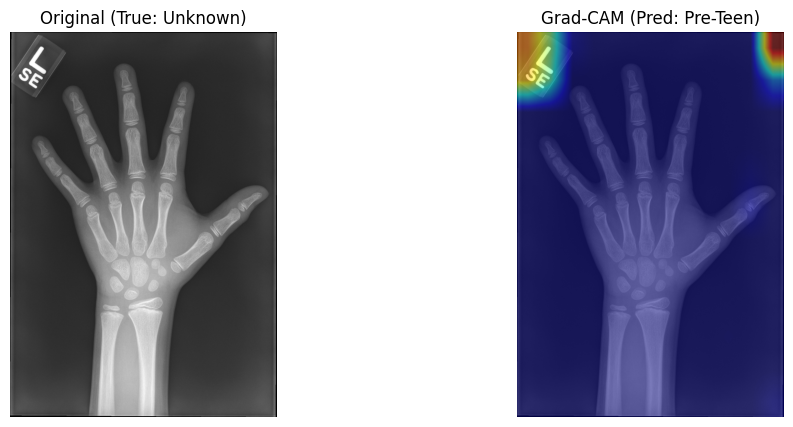

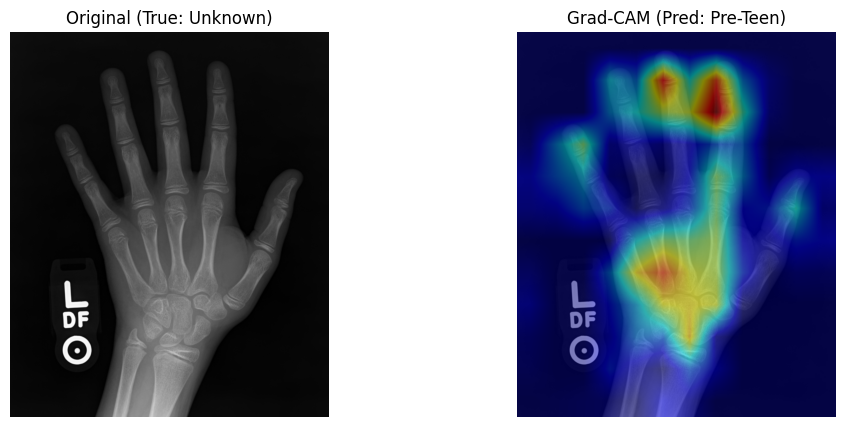

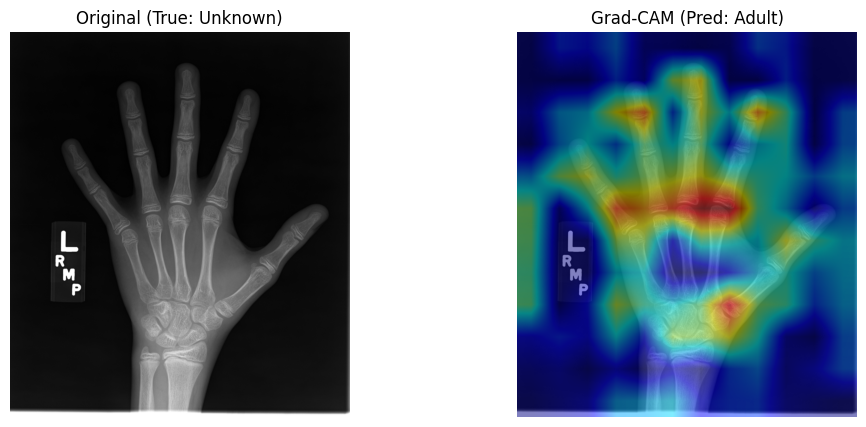

In [20]:
# Cell 16 — Grad-CAM (visualize attention)
# Simple Grad-CAM for CORAL model using the backbone's conv_head as target class
class GradCAM:
    def __init__(self, model, target_module):
        self.model = model
        self.model.eval()
        self.target_module = target_module
        self.activations = None
        self.gradients = None

        def forward_hook(module, inp, out):
            self.activations = out.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        target_module.register_forward_hook(forward_hook)
        target_module.register_backward_hook(backward_hook)

    def generate(self, input_tensor, sex_tensor):
        input_tensor = input_tensor.to(DEVICE)
        sex_tensor = sex_tensor.to(DEVICE).long()
        self.model.zero_grad()

        probas = self.model(input_tensor, sex_tensor)
        expected = torch.sum(probas, dim=1).mean()

        expected.backward(retain_graph=False)

        grads = self.gradients
        acts = self.activations

        weights = grads.mean(dim=(2,3), keepdim=True)
        cam = (weights * acts).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam.squeeze(1).cpu().numpy()

        cam_norm = []
        for c in cam:
            c = c - c.min()
            c = c / (c.max() + 1e-8)
            cam_norm.append(c)

        return np.array(cam_norm)


# Helper show function
def show_gradcam(case_id, sex, model, cam_generator):
    img_path = str(Path(TRAIN_IMG_DIR) / f"{case_id}.png")

    if not os.path.exists(img_path):
        return

    img_original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_rgb = cv2.cvtColor(img_original, cv2.COLOR_GRAY2RGB)

    img_pil = transforms.ToPILImage()(img_rgb)
    img_resized = transforms.Resize((IMG_SIZE, IMG_SIZE))(img_pil)
    img_tensor = transforms.ToTensor()(img_resized)
    img_norm = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )(img_tensor)

    inp = img_norm.unsqueeze(0).to(DEVICE)
    s = torch.tensor([1 if sex == 'M' else 0], dtype=torch.long).to(DEVICE)

    heat = cam_generator.generate(inp, s)[0]

    heat_resized = cv2.resize(heat, (img_rgb.shape[1], img_rgb.shape[0]))
    heat_color = cv2.applyColorMap((heat_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heat_color = cv2.cvtColor(heat_color, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(img_rgb, 0.5, heat_color, 0.5, 0)

    with torch.no_grad():
        probas = model(inp, s)
        pred_class_idx = int(coral_predict(probas)[0])
        pred_stage = CLASS_NAMES[pred_class_idx]

    true_label_str = "Unknown"
    if case_id in train_df_used['Case ID'].values:
        row = train_df_used[train_df_used['Case ID'] == case_id].iloc[0]
        true_label_idx = int(row['age_bin'])
        true_label_str = CLASS_NAMES[true_label_idx]

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.title(f"Original (True: {true_label_str})")
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title(f"Grad-CAM (Pred: {pred_stage})")
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()


# Initialize GradCAM
target_module = best_model.backbone.conv_head
cam = GradCAM(best_model, target_module)

# Visualize a few test samples
print("\n=== Grad-CAM Visualizations (Test Samples) ===")
test_sample_ids = test_holdout_df['Case ID'].sample(3, random_state=42).tolist()

for case_id in test_sample_ids:
    sex_val = test_holdout_df[test_holdout_df['Case ID'] == case_id]['sex'].values[0]
    show_gradcam(case_id, sex_val, best_model, cam)
